# Load and Plot SWOT EXPERT Data

In [1]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
#%matplotlib widget
from scipy.ndimage import generic_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

Log into earthaccess

In [2]:
auth = earthaccess.login(persist=True)

Check the names of the SWOT datasets available on earthaccess

In [3]:
# results = earthaccess.search_datasets(keyword="swot")
# for item in results:
#     summary = item.summary()
#     print(summary["short-name"])

In [4]:
def get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax):
    """
    Searches for SWOT data within the bounding box and time. Note that this doesn't work for unsmoothed data. 
    
    latmin,latmax: latitude bounds, degrees N (south is negative); floats
    lonmin, lonmax: longitude bounds, degrees E (west is negative); floats
    tmin,tmax: temporal bounds; strings of form 'yyyy-mm-dd'
    """
    bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
    results = earthaccess.search_data(
        short_name="SWOT_L2_LR_SSH_EXPERT_2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
    print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
    paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

    return paths

### Looking for Gulf Stream Ring <3 Edward <3

In [5]:
latmin,latmax = 34,38
lonmin,lonmax = -73,-68
tmin,tmax = '2024-04-03','2024-08-05' #'2024-04-17','2024-08-04'

edward_paths = get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax)

Number of swaths: 88


QUEUEING TASKS | :   0%|          | 0/88 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/88 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/88 [00:00<?, ?it/s]

Get all dates with SWOT swaths through the bounding box

In [6]:
dates_available = []
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if today not in dates_available:
        dates_available.append(today)
print(dates_available)

['20240405', '20240406', '20240407', '20240408', '20240416', '20240417', '20240418', '20240420', '20240426', '20240427', '20240428', '20240429', '20240507', '20240508', '20240509', '20240517', '20240518', '20240519', '20240523', '20240527', '20240528', '20240529', '20240530', '20240531', '20240607', '20240608', '20240609', '20240613', '20240617', '20240618', '20240619', '20240620', '20240621', '20240628', '20240629', '20240630', '20240704', '20240708', '20240709', '20240710', '20240711', '20240712', '20240719', '20240720', '20240721', '20240725', '20240729', '20240730', '20240801']


Get data from a specific date

NOTE: 2024/05/23 isn't cropping

In [7]:
date_requested = '20240508'

ind = 0 
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if date_requested == today:
        print(ind)
    ind += 1

23
24


In [8]:
print(edward_paths[23])
print(edward_paths[24])

<File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_014_576_20240508T002317_20240508T011320_PIC0_01.nc>
<File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_015_007_20240508T131334_20240508T140502_PIC0_01.nc>


Open a single dataset

In [9]:
ds1 = xr.open_dataset(edward_paths[23])
ds2 = xr.open_dataset(edward_paths[24])

In [10]:
def crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin+360) & (ds.longitude <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [11]:
ds1_masked = crop_dataset_by_lat_lon(ds1,latmin,latmax,lonmin,lonmax)
ds2_masked = crop_dataset_by_lat_lon(ds2,latmin,latmax,lonmin,lonmax)

Need to add 'height_cor_xover' values to ssh & sla variabiles

In [12]:
# plt.clf()

# fig,ax=plt.subplots(figsize=(8,5))
# plot = ax.pcolormesh(ds1_masked.longitude,ds1_masked.latitude,ds1_masked.height_cor_xover)
# cbar = plt.colorbar(plot,ax=ax)

# cbar.set_label('Height Correction (m)', rotation=270, labelpad=15)

# ax.set_ylabel('Latitude')
# ax.set_xlabel('Longitude')

# plt.show()

SSHA Karin 2 is the best quality to show the eddy

<Figure size 640x480 with 0 Axes>

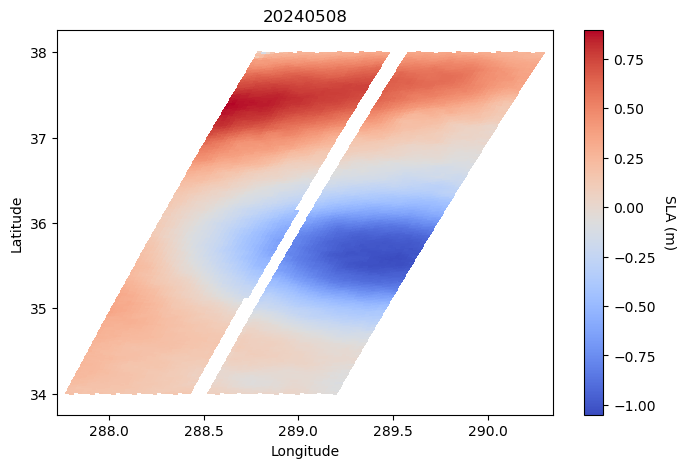

In [13]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds2_masked.longitude,ds2_masked.latitude,np.add(ds2_masked.ssha_karin_2,ds2_masked.height_cor_xover),cmap='coolwarm')#,vmin=-48,vmax=-43)
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA (m)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

Plot overlap

<Figure size 640x480 with 0 Axes>

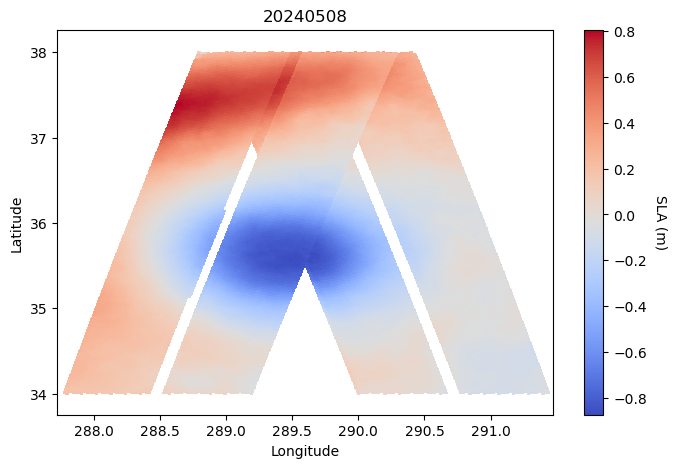

In [14]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds1_masked.longitude,ds1_masked.latitude,np.add(ds1_masked.ssha_karin_2,ds1_masked.height_cor_xover),cmap='coolwarm')#,vmin=-48,vmax=-43)
ax.pcolormesh(ds2_masked.longitude,ds2_masked.latitude,np.add(ds2_masked.ssha_karin_2,ds2_masked.height_cor_xover),cmap='coolwarm')#,vmin=-48,vmax=-43)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA (m)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

Regrid SWOT data to regular grid. Need to do this before taking spatial gradients for velocity calculations.

In [15]:
bbox = (-73, 35, -70, 37) #edward
xv = np.arange(287, 293, 0.036)
yv = np.arange(33,39, 0.036)
grid_x, grid_y = np.meshgrid(xv, yv)
ssh=ds1_masked.ssha_karin_2+ds1_masked.height_cor_xover
lat=ds1_masked.latitude
lon=ds1_masked.longitude
grid_ssh1 = griddata((lon.values.ravel(),lat.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')
ssh=ds2_masked.ssha_karin_2+ds2_masked.height_cor_xover
lat=ds2_masked.latitude
lon=ds2_masked.longitude
grid_ssh2 = griddata((lon.values.ravel(),lat.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')

Plot regridded SSH

<Figure size 640x480 with 0 Axes>

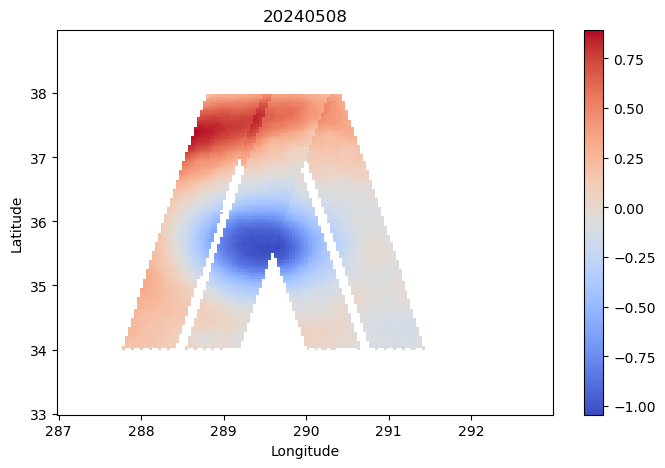

In [16]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh1,cmap='coolwarm')
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh2,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)

# cbar.set_label('dsdx', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

In [17]:
def compute_geos_current(ssh,lat):
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx = 4000 # m i changed it to 4000 to match res? need to double check
    dy = 4000 # m
    gravity = 9.81

    dsdy,dsdx=np.array(np.gradient(ssh, dx, edge_order=1))
    # ds_x,ds_y=np.array(np.gradient(ssh))
    # dsdx=ds_x/dx;
    # dsdy=ds_y/dx;
    vg = (gravity/np.array(f_coriolis))*dsdx
    ug = -(gravity/np.array(f_coriolis))*dsdy
    # ref_gx, ref_gy = gravity/np.array(f_coriolis)*np.array(np.gradient(ssh, dx, edge_order=2))
    geos_current = np.sqrt(ug**2 + vg**2)
    
    return ug,vg,geos_current

Compute geostrophic currents

In [18]:
#Calculate
ug1,vg1,geos_current1 = compute_geos_current(grid_ssh1,grid_y)
ug2,vg2,geos_current2 = compute_geos_current(grid_ssh2,grid_y)

<Figure size 640x480 with 0 Axes>

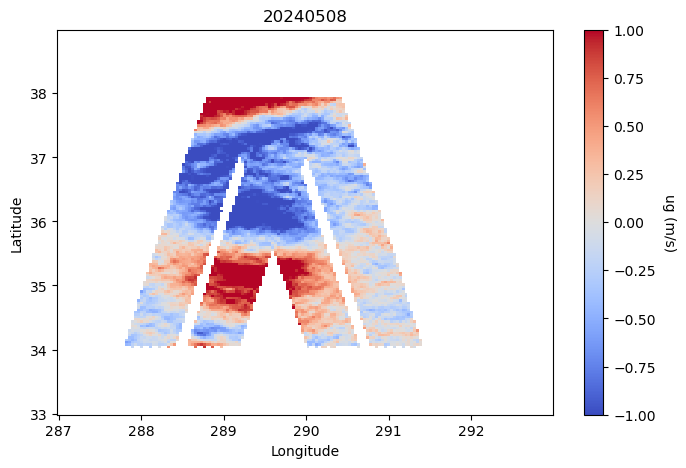

<Figure size 640x480 with 0 Axes>

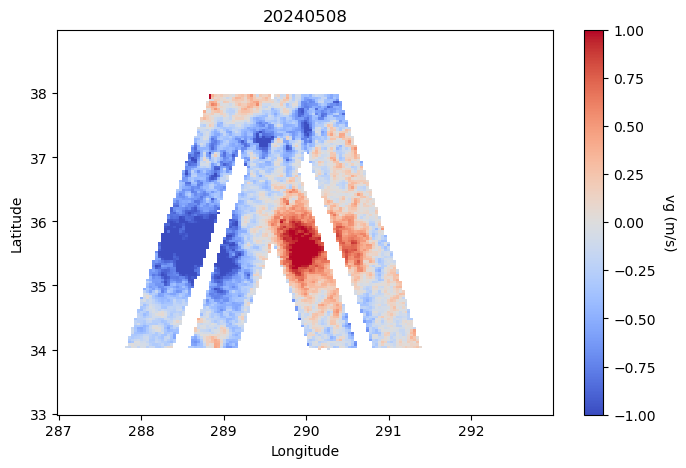

In [19]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,ug1,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(grid_x,grid_y,ug2,cmap='coolwarm',vmin=-1,vmax=1)
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('ug (m/s)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,vg1,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(grid_x,grid_y,vg2,cmap='coolwarm',vmin=-1,vmax=1)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('vg (m/s)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

In [20]:
def compute_relative_vorticity(ug, vg, lat):
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    # ds = self._dset
        
    dx = 4000 # m
    dy = 4000 # m
        
    # du_dx, du_dy = np.gradient(ug, dx, edge_order=2)
    # dv_dx, dv_dy = np.gradient(vg, dx, edge_order=2)
    du_dy, du_dx = np.gradient(ug, dx, edge_order=2)
    dv_dy, dv_dx = np.gradient(vg, dx, edge_order=2)
        
    ksi = (dv_dx - du_dy)/f_coriolis
        
    return ksi

Compute geostrophic vorticity. Smoothing is in the x,y direction, not along track, which is why the swath shrinks. Future problem to fix to increase swath of vorticity

<Figure size 640x480 with 0 Axes>

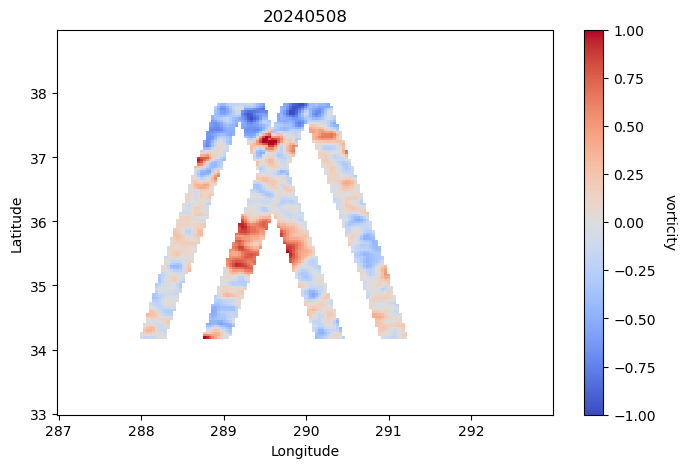

In [21]:
wfl=5
ug_smooth1=xr.apply_ufunc(generic_filter,ug1, np.mean, [wfl,wfl])
vg_smooth1=xr.apply_ufunc(generic_filter,vg1, np.mean, [wfl,wfl])
ug_smooth2=xr.apply_ufunc(generic_filter,ug2, np.mean, [wfl,wfl])
vg_smooth2=xr.apply_ufunc(generic_filter,vg2, np.mean, [wfl,wfl])
# ug_smooth1=gaussian_filter(ug1,1)
# vg_smooth1=gaussian_filter(vg1,1)
# ug_smooth2=gaussian_filter(ug2,1)
# vg_smooth2=gaussian_filter(vg2,1)
ksi1=compute_relative_vorticity(ug_smooth1, vg_smooth1, grid_y)
ksi2=compute_relative_vorticity(ug_smooth2, vg_smooth2, grid_y)

plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,ksi1,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(grid_x,grid_y,ksi2,cmap='coolwarm',vmin=-1,vmax=1)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('vorticity', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()

In [22]:
results = earthaccess.search_datasets(instrument="oci")

tspan = ("2024-05-08", "2024-05-08")
#bbox = (-58, 37.5, -52, 41) #howie
bbox = (-73, 35, -70, 37) #edward
# bbox=(-61, 34, -59, 39) #patrick
clouds = (0, 100)
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

paths = earthaccess.open(results) #'streaming' data

datatree = open_datatree(paths[0])
datatree
dataset = xr.merge(datatree.to_dict().values())
dataset
dataset = dataset.set_coords(("longitude", "latitude"))

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
grid_x_180 = grid_x - 360 #only works for >180˚

In [ ]:
h=str(paths[0])
datey=h[64:72]

Text(0.5, 1.0, '2024-05-08')

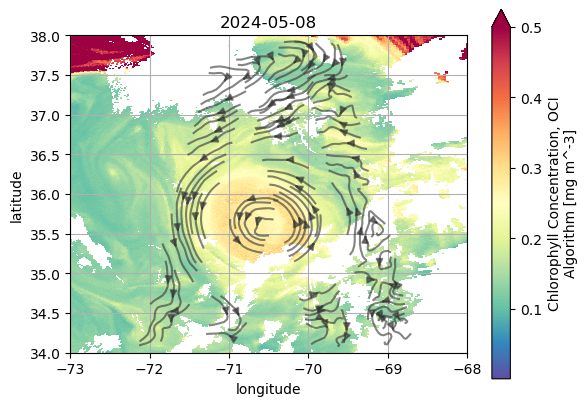

In [29]:
fig = plt.figure()
ax = plt.axes()#projection=ccrs.PlateCarree())
#ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot=dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="Spectral_r", vmax=0.5, ax=ax) #tried adding ,transform=ccrs.PlateCarree()
#plot=plt.pcolor(dataset["longitude"].values,dataset["latitude"].values,dataset["chlor_a"].values, cmap="Spectral_r", vmax=0.5,transform=ccrs.PlateCarree())
ax.grid(True)
#ax.streamplot(grid_x_180,grid_y,ug1,vg1,transform=ccrs.PlateCarree(), density = 2, color = (0.2,0.2,0.2,0.6))
#ax.streamplot(grid_x_180,grid_y,ug2,vg2,transform=ccrs.PlateCarree(), density = 2, color = (0.2,0.2,0.2,0.6))
ax.streamplot(grid_x_180,grid_y,ug1,vg1, density = 3, color = (0.2,0.2,0.2,0.6))
ax.streamplot(grid_x_180,grid_y,ug2,vg2, density = 3, color = (0.2,0.2,0.2,0.6))
ax.axis("scaled")
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_ylim([34,38])
ax.set_xlim([-73,-68])
ax.set_title(datey[0:4]+'-'+datey[4:6]+'-'+datey[6:len(datey)])

Text(0.5, 1.0, '2024-05-08')

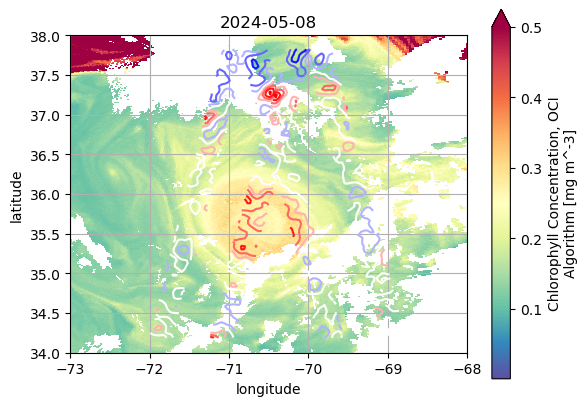

In [25]:
fig = plt.figure()
ax = plt.axes()#projection=ccrs.PlateCarree())
#ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot=dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="Spectral_r", vmax=0.5, ax=ax) #tried adding ,transform=ccrs.PlateCarree()
#plot=plt.pcolor(dataset["longitude"].values,dataset["latitude"].values,dataset["chlor_a"].values, cmap="Spectral_r", vmax=0.5,transform=ccrs.PlateCarree())
ax.grid(True)
#ax.streamplot(grid_x_180,grid_y,ug1,vg1,transform=ccrs.PlateCarree(), density = 2, color = (0.2,0.2,0.2,0.6))
#ax.streamplot(grid_x_180,grid_y,ug2,vg2,transform=ccrs.PlateCarree(), density = 2, color = (0.2,0.2,0.2,0.6))
ax.contour(grid_x_180,grid_y,ksi1,cmap='bwr',vmin=-1,vmax=1)
ax.contour(grid_x_180,grid_y,ksi2,cmap='bwr',vmin=-1,vmax=1)
ax.axis("scaled")
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_ylim([34,38])
ax.set_xlim([-73,-68])
h=str(paths[0])
datey=h[64:72]
ax.set_title(datey[0:4]+'-'+datey[4:6]+'-'+datey[6:len(datey)])

<Figure size 640x480 with 0 Axes>

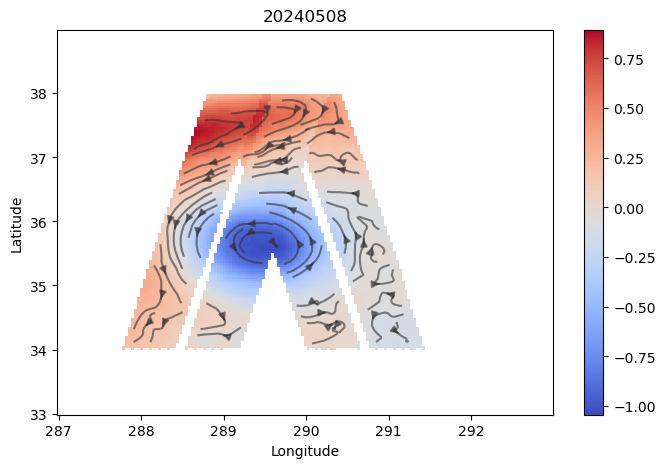

In [26]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh1,cmap='coolwarm')
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh2,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)
plt.streamplot(grid_x,grid_y,ug1,vg1, density = 2, color = (0.2,0.2,0.2,0.6))
plt.streamplot(grid_x,grid_y,ug2,vg2, density = 2, color = (0.2,0.2,0.2,0.6))

# cbar.set_label('dsdx', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

plt.show()